# Speech model creation

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
Features = pd.read_csv("../../data/aud_em/features.csv")

In [4]:
# Convertir las columnas de la primera a la penúltima de tipo str a tipo float
Features = Features.drop(Features.columns[0], axis=1)
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11199 entries, 0 to 11198
Columns: 1969 entries, feature_0 to emotion
dtypes: float64(1968), object(1)
memory usage: 168.2+ MB


In [5]:
# CUIDADO
Features = Features.drop(Features[Features['emotion'] == 'neutral'].index)

In [6]:
Features["emotion"].unique()

array(['anger', 'fear', 'joy', 'surprise', 'sadness'], dtype=object)

In [7]:
# Suponiendo que la columna "emotion" está en el dataframe "Features":
Features['emotion'].replace({'anger': 'high', 'fear': 'high', 'joy': 'low', 'neutral': 'high', 'surprise': 'low', 'sadness': 'high'}, inplace=True)
Features["emotion"].unique()

array(['high', 'low'], dtype=object)

In [8]:
X = Features.iloc[: ,:-1].values
Y = Features['emotion'].values

In [9]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7186, 1968), (7186, 2), (1797, 1968), (1797, 2))

In [11]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7186, 1968), (7186, 2), (1797, 1968), (1797, 2))

In [12]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((7186, 1968, 1), (7186, 2), (1797, 1968, 1), (1797, 2))

In [13]:
import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2023-05-21 14:27:13.046597: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-05-21 14:27:14.410822: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-21 14:27:14.415883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-21 14:27:16.055064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 14:27:16.055194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-21 14:27:16.055218: I tensorflow/stream_executor/platform/de

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=1e-5)
cp = ModelCheckpoint('savedSpeech/', save_best_only=True)

callbacks = [cp, early_stopping, reduce_lr]

In [17]:
from keras_tuner.engine import tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from kerastuner import RandomSearch, HyperParameters

def build_model(hp):

    model = Sequential()
    model.add(Conv1D(hp.Int("conv1_filters", min_value=16, max_value=512, step=32), kernel_size=hp.Int("conv1_kernel_size", min_value=3, max_value=7, step=2), strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=hp.Int("pool1_size", min_value=3, max_value=7, step=2), strides=hp.Int("pool1_strides", min_value=1, max_value=3, step=1), padding='same'))

    model.add(Conv1D(hp.Int("conv2_filters", min_value=16, max_value=512, step=32), kernel_size=hp.Int("conv2_kernel_size", min_value=3, max_value=7, step=2), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Int("pool2_size", min_value=3, max_value=7, step=2), strides=hp.Int("pool2_strides", min_value=1, max_value=3, step=1), padding='same'))

    model.add(Conv1D(hp.Int("conv3_filters", min_value=16, max_value=512, step=32), kernel_size=hp.Int("conv3_kernel_size", min_value=3, max_value=7, step=2), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Int("pool3_size", min_value=3, max_value=7, step=2), strides=hp.Int("pool3_strides", min_value=1, max_value=3, step=1), padding='same'))
    model.add(Dropout(hp.Float("dropout1", min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Conv1D(hp.Int("conv4_filters", min_value=16, max_value=512, step=32), kernel_size=hp.Int("conv4_kernel_size", min_value=3, max_value=7, step=2), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Int("pool4_size", min_value=3, max_value=7, step=2), strides=hp.Int("pool4_strides", min_value=1, max_value=3, step=1), padding='same'))

    model.add(Flatten())
    model.add(Dense(units=hp.Int("dense_units", min_value=16, max_value=256, step=16), activation='relu'))
    model.add(Dropout(hp.Float("dropout2", min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(units=2, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(hp.Float("learning_rate", min_value=1e-6, max_value=1e-2, sampling="LOG"))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=40,
    executions_per_trial=1,
    directory='./savedSpeech/fine_tuned/',
    project_name='HP_CNN'
)

# Resumen de la búsqueda
tuner.search_space_summary()



INFO:tensorflow:Reloading Tuner from ./savedSpeech/fine_tuned/HP_CNN/tuner0.json
Search space summary
Default search space size: 20
conv1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
conv1_kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': 'linear'}
pool1_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': 'linear'}
pool1_strides (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
conv2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
conv2_kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': 'linear'}
pool2_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': 'linear'}
pool2_strid

/tmp/ipykernel_9124/2357461865.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch, HyperParameters


In [18]:
BATCH_SIZE=32
tuner.search(x_train, y_train,
             epochs=5,
             validation_split=0.1,
             batch_size=BATCH_SIZE,
             callbacks=callbacks)


INFO:tensorflow:Oracle triggered exit


In [19]:
best_hp_4CNN = tuner.get_best_hyperparameters()[0]

print("Mejores hiperparámetros encontrados:")
print_hyperparameters(best_hp_4CNN.get_config())
print(type(best_hp_4CNN))

Mejores hiperparámetros encontrados:
conv1_filters: 16
conv1_kernel_size: 3
conv2_filters: 48
conv2_kernel_size: 3
conv3_filters: 496
conv3_kernel_size: 3
conv4_filters: 400
conv4_kernel_size: 7
dense_units: 240
dropout1: 0.4
dropout2: 0.5
learning_rate: 0.00022993196357666725
pool1_size: 3
pool1_strides: 3
pool2_size: 5
pool2_strides: 3
pool3_size: 5
pool3_strides: 3
pool4_size: 3
pool4_strides: 3
<class 'keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters'>


In [19]:
import pickle
filename = 'best_hp_4CNN3.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_hp_4CNN, file)

## HIPERPARAMETROS CONSEGUIDOS

In [14]:
def print_hyperparameters(json_data):
    values = json_data["values"]

    for key, value in sorted(values.items()):
        print(f"{key}: {value}")

In [14]:
import pickle
filename = 'best_hp_4CNN3.pkl'
with open(filename, 'rb') as file:
    best_hp_4CNN = pickle.load(file)

In [20]:
print_hyperparameters(best_hp_4CNN.get_config())

conv1_filters: 16
conv1_kernel_size: 3
conv2_filters: 48
conv2_kernel_size: 3
conv3_filters: 496
conv3_kernel_size: 3
conv4_filters: 400
conv4_kernel_size: 7
dense_units: 240
dropout1: 0.4
dropout2: 0.5
learning_rate: 0.00022993196357666725
pool1_size: 3
pool1_strides: 3
pool2_size: 5
pool2_strides: 3
pool3_size: 5
pool3_strides: 3
pool4_size: 3
pool4_strides: 3


In [21]:
from keras_tuner.engine import tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from kerastuner import RandomSearch, HyperParameters
def best_model(hp):
    model = Sequential()
    model.add(Conv1D(best_hp_4CNN.get('conv1_filters'), kernel_size=best_hp_4CNN.get('conv1_kernel_size'), strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=best_hp_4CNN.get('pool1_size'), strides=best_hp_4CNN.get('pool1_strides'), padding='same'))
    model.add(Conv1D(best_hp_4CNN.get('conv2_filters'), kernel_size=best_hp_4CNN.get('conv2_kernel_size'), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=best_hp_4CNN.get('pool2_size'), strides=best_hp_4CNN.get('pool2_strides'), padding='same'))
    model.add(Conv1D(best_hp_4CNN.get('conv3_filters'), kernel_size=best_hp_4CNN.get('conv3_kernel_size'), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=best_hp_4CNN.get('pool3_size'), strides=best_hp_4CNN.get('pool3_strides'), padding='same'))
    model.add(Dropout(best_hp_4CNN.get('dropout1')))
    model.add(Conv1D(best_hp_4CNN.get('conv4_filters'), kernel_size=best_hp_4CNN.get('conv4_kernel_size'), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=best_hp_4CNN.get('pool4_size'), strides=best_hp_4CNN.get('pool4_strides'), padding='same'))
    model.add(Flatten())
    model.add(Dense(units=best_hp_4CNN.get('dense_units'), activation='relu'))
    model.add(Dropout(best_hp_4CNN.get('dropout2')))
    model.add(Dense(units=2, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(best_hp_4CNN.get('learning_rate'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [27]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

best_model_CNN = best_model(best_hp_4CNN)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=1e-5)
historySpeech= best_model_CNN.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping,reduce_lr])

Epoch 1/100
225/225 [==============================] - 5s 20ms/step - loss: 0.6196 - accuracy: 0.6808 - val_loss: 0.6007 - val_accuracy: 0.7106
Epoch 2/100
225/225 [==============================] - 4s 19ms/step - loss: 0.6009 - accuracy: 0.6924 - val_loss: 0.5926 - val_accuracy: 0.7106
Epoch 3/100
225/225 [==============================] - 4s 19ms/step - loss: 0.6111 - accuracy: 0.6822 - val_loss: 0.5787 - val_accuracy: 0.7106
Epoch 4/100
225/225 [==============================] - 4s 19ms/step - loss: 0.5972 - accuracy: 0.6847 - val_loss: 0.6027 - val_accuracy: 0.7262
Epoch 5/100
225/225 [==============================] - 4s 19ms/step - loss: 0.5962 - accuracy: 0.6922 - val_loss: 0.5775 - val_accuracy: 0.7257
Epoch 6/100
225/225 [==============================] - 4s 19ms/step - loss: 0.6024 - accuracy: 0.6859 - val_loss: 0.5756 - val_accuracy: 0.7279
Epoch 7/100
225/225 [==============================] - 4s 19ms/step - loss: 0.5915 - accuracy: 0.6950 - val_loss: 0.5692 - val_accuracy:

57/57 [==============================] - 0s 6ms/step - loss: 0.5617 - accuracy: 0.7351
Accuracy of our model on test data :  73.51140975952148 %


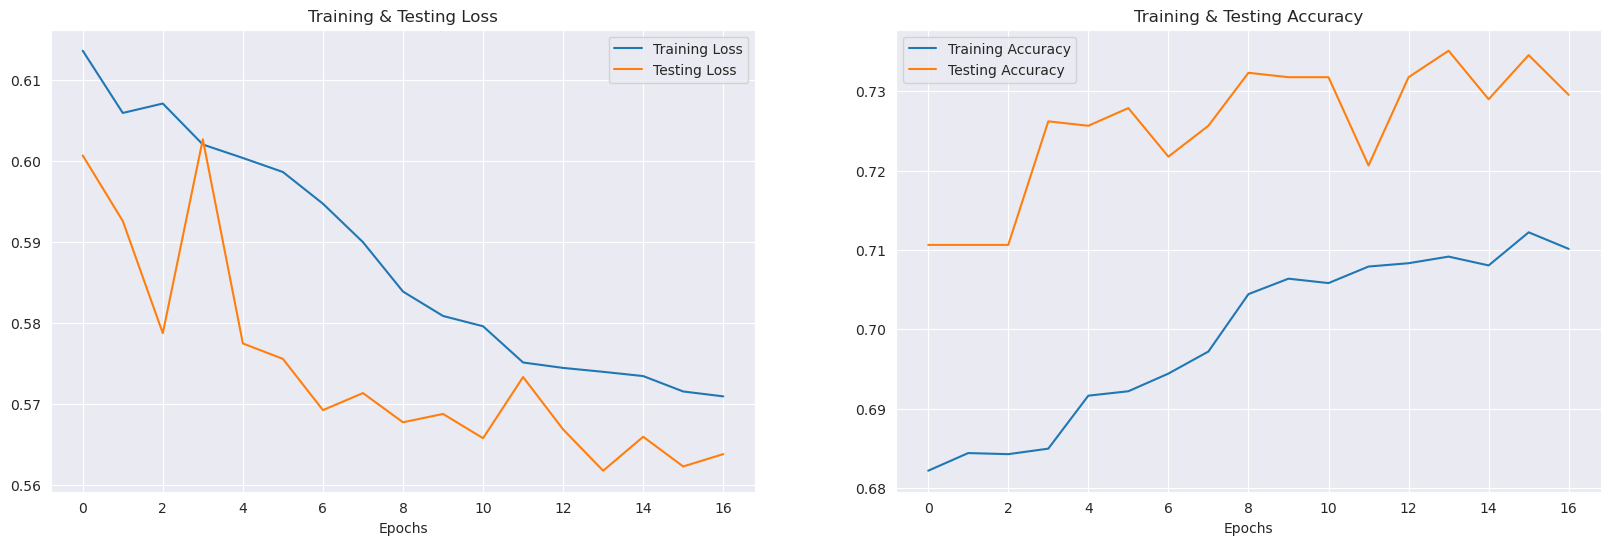

In [28]:
from matplotlib import pyplot as plt

num_epochs = len(historySpeech.epoch)

print("Accuracy of our model on test data : " , best_model_CNN.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = historySpeech.history['accuracy']
train_loss = historySpeech.history['loss']
test_acc = historySpeech.history['val_accuracy']
test_loss = historySpeech.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [30]:
# predicting on test data.
pred_test = best_model_CNN.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [31]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,high,low
1,high,low
2,high,high
3,high,high
4,low,low
5,high,high
6,high,low
7,high,low
8,high,high
9,high,high


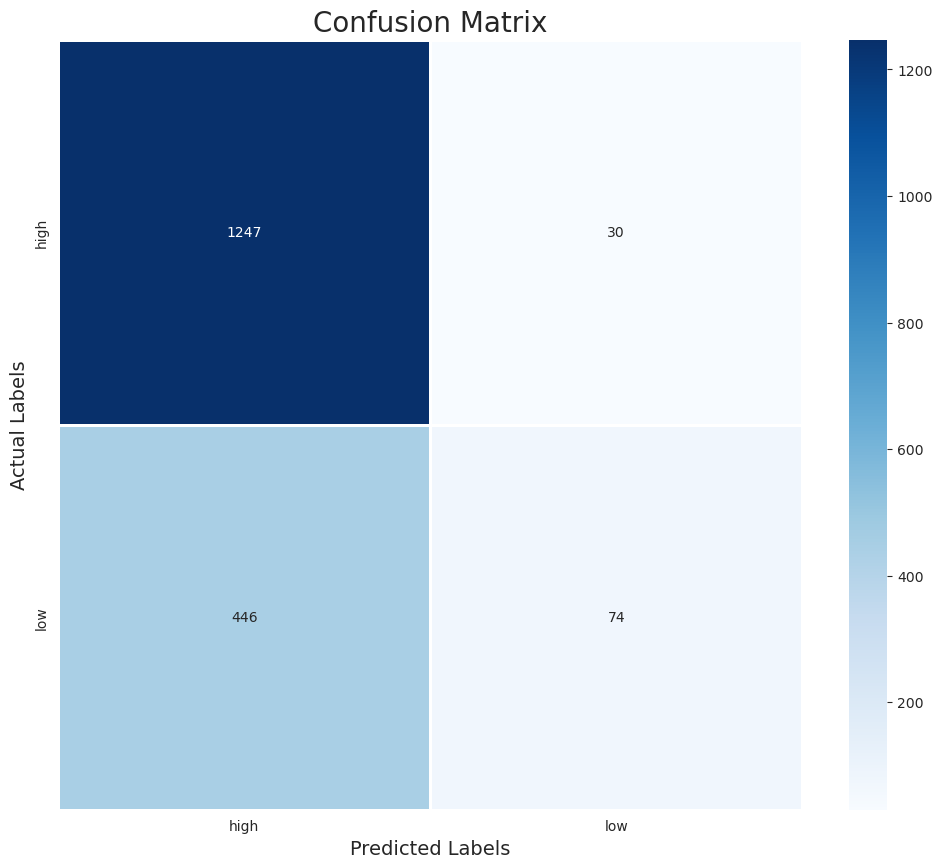

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.74      0.98      0.84      1277
         low       0.71      0.14      0.24       520

    accuracy                           0.74      1797
   macro avg       0.72      0.56      0.54      1797
weighted avg       0.73      0.74      0.67      1797



In [38]:
best_model_CNN.save('modelo_entrenado.h5')
type(best_model_CNN)

tensorflow.python.keras.engine.sequential.Sequential

In [35]:
from tensorflow.keras.models import load_model

# Carga el modelo desde el archivo
modelo_cargado = load_model('modelo_entrenado.h5')